In [1]:
import os
from os.path import isdir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

D:\Miniconda2\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Loading and Reshaping Data

We'll start again by reading in the data we extracted earlier. We'll still only be reading in the command words as these are what the neural network will be trained on.

In [2]:
words = os.listdir('../data/train')
command_words = sorted(['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence'])


def load_word(fold, word, augmented=False):
    """
    Reads in MFCC data for a single word in a given fold
    Returns tuple of X and y data for that word
    """
    if word != 'silence' and fold == 'train' and augmented:
        X = np.load('../data/{}/{}/mfcc_augmented.npy'.format(fold, word))
    else:
        X = np.load('../data/{}/{}/mfcc.npy'.format(fold, word))
    y = np.full(shape=X.shape[0],
                fill_value=word if word in command_words else 'unknown')
    return X, y

def get_fold_data(fold, words=words, augmented=False):
    """
    Reads in mfcc data  and labels for entire fold
    fold: 'train', 'validation', or 'test'
    words: list of words to extract
    augmented: boolean value that determines if the augmented data is loaded along with the given data
    """
    
    X_total = np.array([]).reshape(0, 20 , 32)
    y_total = np.array([])
    for word in words:
        X_word, y_word = load_word(fold, word, augmented)
        X_total = np.vstack([X_total, X_word])
        y_total = np.append(y_total, y_word)
        
    return X_total, y_total


X_train, y_train = get_fold_data('train', command_words)
X_val, y_val = get_fold_data('validation', command_words)
X_test, y_test = get_fold_data('test', command_words)

print('Number of training samples: {}'.format(len(X_train)))
print('Number of validation samples: {}'.format(len(X_val)))
print('Number of testing samples: {}'.format(len(X_test)))
print('Shape of each sample: {}'.format(X_train[0].shape))

Number of training samples: 34069
Number of validation samples: 4153
Number of testing samples: 4524
Shape of each sample: (20, 32)


In [3]:
#holds counts of each word for each fold
word_counts = pd.DataFrame()
for fold, y in zip(['train', 'validation', 'test'], [y_train, y_val, y_test]):
    word_counts[fold] = pd.Series(y).value_counts()
word_counts = word_counts.sort_index()
word_counts

,train,validation,test
down,3134,377,406
go,3106,372,402
left,3037,352,412
no,3130,406,405
off,2970,373,402
on,3086,363,396
right,3019,363,396
silence,3300,450,450
stop,3111,350,411
up,2948,350,425


Now that we've loaded in the data, we'll need to follow the same process of reformatting it a little so that we can feed it into our neural networks. For the y values, we'll need to transform the labelled words into one hot encoded integers. We'll also need to reshape the X values so that it can be treated as an image.

In [4]:
def reformat_X(X):
    """
    Reshapes X into an 'image' of depth 1
    """
    X = X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    return X

def reformat_y(y):
    """
    Formats y into one hot encoded integers
    """
    y = LabelEncoder().fit_transform(y)
    y = to_categorical(y)
    return y

X_train_img = reformat_X(X_train)
X_val_img = reformat_X(X_val)
X_test_img = reformat_X(X_test)

y_train_hot = reformat_y(y_train)
y_val_hot = reformat_y(y_val)
y_test_hot = reformat_y(y_test)
    
print('X_train shape: {}'.format(X_train_img.shape))
print('y_train_hot shape: {}'.format(y_train_hot.shape))

X_train shape: (34069, 20, 32, 1)
y_train_hot shape: (34069, 11)


# Convolutional Neural Network

Let's see how a convolutional neural network performs on the data. We'll need to flatten the X values and normalize them first so that the optimizer won't get stuck. For this model, we'll be using the default Adam optimizer. We'll also add an early stopping monitor so that the model stops running once the validation loss hasn't decreased in 3 epochs.

In [5]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train_img[0].shape)))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(2, 2), activation='relu'))
model.add(Conv2D(512, kernel_size=(2, 2), activation='relu'))
model.add(Dropout(0.2))
model.add(GlobalMaxPooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(11, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(X_train_img, y_train_hot, batch_size=128, epochs=100, verbose=1,
          validation_data=(X_val_img, y_val_hot), callbacks=[EarlyStopping(patience=3)])

Train on 34069 samples, validate on 4153 samples
Epoch 1/100
34069/34069 [==============================] - 11s 337us/step - loss: 1.1294 - acc: 0.5994 - val_loss: 0.5069 - val_acc: 0.8379
Epoch 2/100
34069/34069 [==============================] - 9s 257us/step - loss: 0.5890 - acc: 0.8029 - val_loss: 0.4219 - val_acc: 0.8611
Epoch 3/100
34069/34069 [==============================] - 9s 257us/step - loss: 0.4588 - acc: 0.8461 - val_loss: 0.2939 - val_acc: 0.9049
Epoch 4/100
34069/34069 [==============================] - 9s 256us/step - loss: 0.3780 - acc: 0.8745 - val_loss: 0.2708 - val_acc: 0.9071
Epoch 5/100
34069/34069 [==============================] - 9s 256us/step - loss: 0.3261 - acc: 0.8922 - val_loss: 0.2726 - val_acc: 0.9107
Epoch 6/100
34069/34069 [==============================] - 9s 255us/step - loss: 0.3041 - acc: 0.8978 - val_loss: 0.2354 - val_acc: 0.9191
Epoch 7/100
34069/34069 [==============================] - 9s 254us/step - loss: 0.2776 - acc: 0.9080 - val_loss: 0.

In [6]:
score = model.evaluate(x=X_test_img, y=y_test_hot)

for name, value in zip(model.metrics_names, score):
    print(name, value)

4524/4524 [==============================] - 0s 98us/step
loss 0.2044555310551614
acc 0.9339080460297123


We already see an improvement in accuracy from our feedforward neural network from ~81% to ~93%. The loss also decreased from ~0.62 to ~0.21.

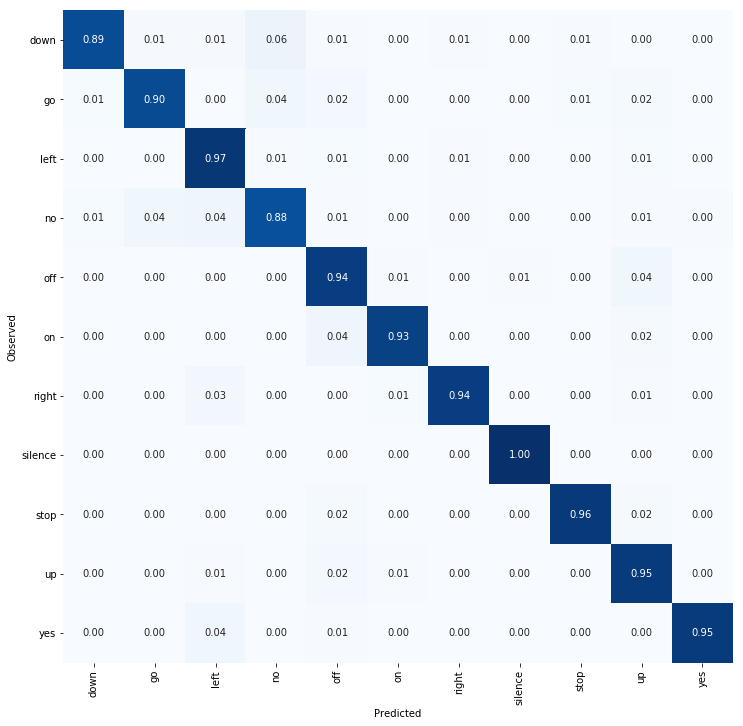

In [7]:
def plot_confusion_matrix(y_obs_labels, y_pred_classes, words=command_words):
    y_pred_labels = np.array([words[y] for y in y_pred_classes])
    conf_matrix = confusion_matrix(y_obs_labels, y_pred_labels)
    conf_matrix_percent = np.divide(conf_matrix.T, conf_matrix.sum(axis=1)).T
    fig, ax = plt.subplots(figsize=(12, 12))    
    sns.heatmap(conf_matrix_percent, cmap='Blues', ax=ax, annot=True, fmt='.2f', cbar=False)
    ax.set_xticklabels(sorted(words), rotation=90)
    ax.set_yticklabels(sorted(words), rotation=0)
    ax.set_ylabel('Observed')
    ax.set_xlabel('Predicted')
    plt.show()
    return conf_matrix_percent  
    
y_pred_val = model.predict_classes(x=X_val_img)
plot_confusion_matrix(y_val, y_pred_val);

This confusion matrix shows us more clearly the vast improvements the CNN has over the simpler models. It's starting to approach the ideal confusion matrix of a straight line down the main diagonal. Still, it has the most trouble classifying "no" and "go," often confusing them for each other or predicting them to be "down." Hopefully, adding in augmented data later will help decrease these misclassifications further.

# Adding Unknown Detection

One last feature the models have been missing so far is to classify words not in the command set as "unknown." We could train it on the 25 words not in the command words set, and label them as unknown. This would work with the data we're given, but we want it to be able to predict any given word or noise it doesn't understand as unknown. One way of doing this is to train on the command words and to validate and test on the entire sample set, classifying any words under a certain confidence threshold as "unknown." We can then tune this confidence threshold to maximize accuracy, or maybe minimize false positive rate depending on which metric is considered more important.

Let's start by testing on the entire dataset and seeing what distribution of confidences our model is giving for words it classifies correctly, those in the command words set it misclassifies, and unknown words.

In [8]:
#reading in entire dataset
X_train_total, y_train_total = get_fold_data('train')
X_val_total, y_val_total = get_fold_data('validation')
X_test_total, y_test_total = get_fold_data('test')

X_img_total = {'train': reformat_X(X_train_total),
              'val': reformat_X(X_val_total),
              'test': reformat_X(X_test_total)}

y_obs_total = {'train': y_train_total,
               'val': y_val_total,
               'test': y_test_total}

#predicting probabilities and classes on entire dataset
y_pred_proba_total = {'train': model.predict(X_img_total['train']),
                      'val': model.predict(X_img_total['val']),
                      'test': model.predict(X_img_total['test'])}


y_pred_classes_total = {'train': model.predict_classes(X_img_total['train']),
                        'val': model.predict_classes(X_img_total['val']),
                        'test': model.predict_classes(X_img_total['test'])}

In [9]:
#writing functions to help evaluate model performance

def create_summary_df(y_obs, y_pred_proba, y_pred_classes):
    labels = command_words + ['unknown']
    df = pd.DataFrame()
    df['y_obs_words'] = y_obs
    df['y_pred_words'] = [labels[class_no] for class_no in y_pred_classes]
    df['max_confidences'] = y_pred_proba.max(axis=1)
    
    def classify_labels(row):
        if row['y_obs_words'] == 'unknown':
            return 'word not in training set'
        elif row['y_obs_words'] == row['y_pred_words']:
            return 'correct'
        else:
            return 'misclassified'
        
    df['labels'] = df.apply(classify_labels, axis=1)
    df['is_correct'] = (df['labels']=='correct')
    return df


def plot_hist(df, ax, color, ylabel, xlabel=False, title=False):
        hist = df[['labels', 'max_confidences']].hist(by='labels', color=color, ax=ax, bins=20)
        hist[0].set_ylabel(ylabel)
        for ax in hist:
            ax.set_xticks(np.linspace(0, 1, num=21))
        if not title:
            for ax in hist:
                ax.set_title('')
        if xlabel:
            for ax in hist:
                ax.set_xlabel('maximum classification confidence')          
        return hist
    
    
def plot_hist_grid(y_obs, y_pred_proba, y_pred_classes, title=''):
    train_df = create_summary_df(y_obs['train'], y_pred_proba['train'], y_pred_classes['train'])
    val_df = create_summary_df(y_obs['val'], y_pred_proba['val'], y_pred_classes['val'])
    
    fig, ax = plt.subplots(2, 3, figsize=(15 , 8))
    plot_hist(train_df, color='C0', title=True, ylabel='train samples', ax=ax[0])
    plot_hist(val_df, color='C1', ylabel='validation samples', xlabel=True, ax=ax[1])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(title)
    return ax


def plot_roc_curve(df, ax):
    fpr, tpr, _ = roc_curve(df['is_correct'], df['max_confidences'])

    ax.step(fpr, tpr, color='b', alpha=0.2,
         where='post')
    ax.fill_between(fpr, tpr, step='post', alpha=0.2,
                 color='b')

    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    ax.set_aspect('equal')
    return ax;

def modify_pred_classes(y_pred_proba, y_pred_classes, thresh=.95):
    """
    Manually classifies words with a confidence of less than thresh as unknown
    """
    probs = y_pred_proba.max(axis=1)
    is_unknown = probs < thresh
    y_pred_modified = y_pred_classes.copy()
    y_pred_modified[is_unknown] = 11
    return y_pred_modified
  
    
def score_with_unknown(y_obs, y_pred_classes, words=command_words+['unknown']):
    """
    Calculates accuracy with unknown words
    """
    pred_words = np.array([words[y] for y in y_pred_classes])
    accuracy = (pred_words == y_obs).sum()/y_obs.size
    return accuracy

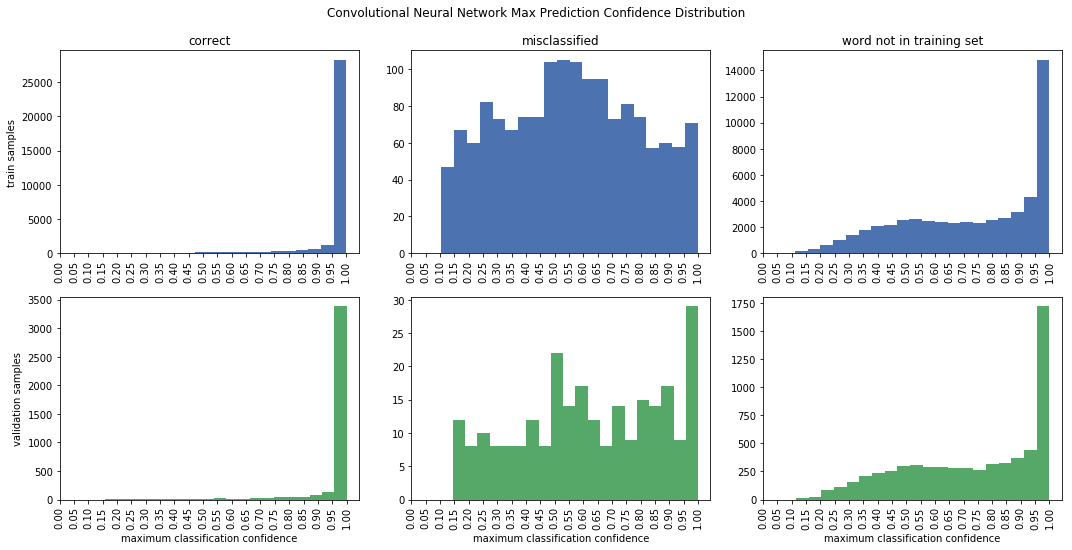

In [10]:
plot_hist_grid(y_obs_total, y_pred_proba_total, y_pred_classes_total,
               title='Convolutional Neural Network Max Prediction Confidence Distribution');

The convolutional neural network tends to be very confident in its predictions for correctly classified words. For words it knows that it misclassifies, the model can be anywhere from not confident at all to very confident. For words outside the command words set, the model tends to predict with very high confidence most of the time, but can also predict with low and medium confidence fairly frequently as well. Again, this could be due to the words sounding familiar to ones it does know (e.g. "nine" and "no").

Based on the histograms above, we will want to set our threshold for predicting as unknown right around .95. This will eliminate most of the misclassified words it should know (the kind of error we want to avoid the most) without removing too many of the correctly classified words.

train accuracy: 0.7610814245033638
val accuracy: 0.757645479819768
test accuracy: 0.7512876473155827


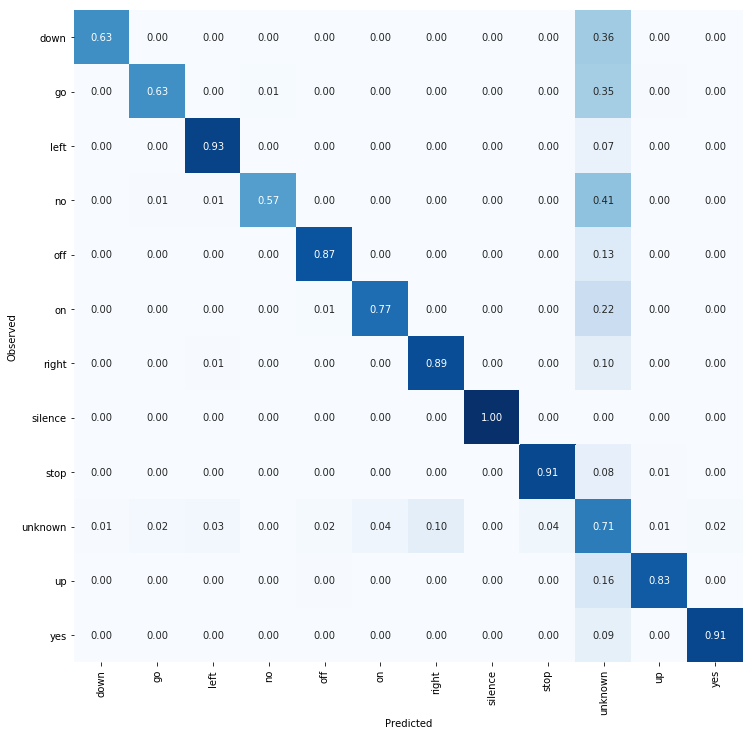

In [11]:
#reclassifying words with a threshold less than .95 as 'unknown'
y_pred_modified = {
    fold: modify_pred_classes(y_pred_proba_total[fold],
                              y_pred_classes_total[fold], thresh=.95)
    for fold in ['train', 'val', 'test']
}

#calculating new accuracy
for fold in ['train', 'val', 'test']:
    print(fold, 'accuracy:', score_with_unknown(y_obs_total[fold], y_pred_modified[fold]))

plot_confusion_matrix(y_obs_total['test'], y_pred_modified['test'], words=command_words+['unknown']);

Although we only have an accuracy of around 76% across the folds, the accuracy for most individual word is considerably higher than that. This is because of the large class disparity - over half of the total words are 'unknown'. These words are bringing down the overall accuracy. Still, we have very few other false positives. For command words, the model tends to predict them correctly or as unknown when it's not confident enough. This is exactly how we want it to behave.

This model works well enough that we could stop here. Still, it has a hard time classifying the words "no," "go," and "down." Looking forward, we will want to add augmented data for these words to help it classify them and improve performance further.